In [1]:
import ee, geemap, geopandas as gpd
import matplotlib.pyplot as plt , seaborn as sns
from math import ceil
from shapely.geometry import Polygon
import os
ee.Initialize()

In [20]:
from data_downloader import Get_sentinel_raster

<AxesSubplot:>

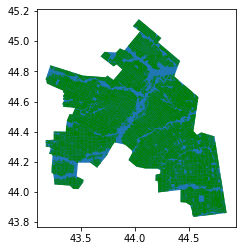

In [25]:
fields = gpd.read_file('vector/cliped_by_Region_agriculture_mask_fields.geojson')
mask = gpd.read_file('vector/Region_agriculture_mask.geojson')

fig, ax = plt.subplots(1, 1)

mask.plot(ax = ax)
fields.plot(color = 'g', ax = ax)



In [26]:
Get_sentinel_raster(mask, 'train_for_nn')

Row:   0%|          | 0/9 [00:00<?, ?it/s]

--------------------
скачивание батчей...
Generating URL ...


An error occurred while downloading.
Image.clipToBoundsAndScale: The geometry for image clipping must not be empty.
Generating URL ...


An error occurred while downloading.
Image.clipToBoundsAndScale: The geometry for image clipping must not be empty.
Generating URL ...


An error occurred while downloading.
Image.clipToBoundsAndScale: The geometry for image clipping must not be empty.
Generating URL ...


An error occurred while downloading.
Image.clipToBoundsAndScale: The geometry for image clipping must not be empty.
Generating URL ...


An error occurred while downloading.
Image.clipToBoundsAndScale: The geometry for image clipping must not be empty.
Generating URL ...


An error occurred while downloading.
Image.clipToBoundsAndScale: The geometry for image clipping must not be empty.
Generating URL ...


An error occurred while downloading.
Image.clipToBoundsAndScale: The geometry for image clipping must not be empty.
Generating URL ...


An error occurred while downloading.
Image.clipToBoundsAndScale: The geometry for image clipping must not be empty.
Generating URL ...
Please wait ...


Data downloaded to d:\python_notebooks\total_archangelskiy\regional_scale\raster\batch_download\0_8.tif
Generating URL ...
Please wait ...
